# Import python dataset

In [55]:
k = 821
notebookName = 'AAE-NEW_'

In [56]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import pandas as pd
import time
import matplotlib.ticker as mticker
import joblib

import tensorflow.keras.backend as backend
from keras import Input, Model
from keras.models import Sequential, Model
from keras.layers import Dense, Reshape, Flatten, LeakyReLU, ReLU, Dropout, BatchNormalization, Activation
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise ,Conv1DTranspose
from keras.layers.convolutional import UpSampling2D,UpSampling1D, Conv2D,Conv1D,Conv2DTranspose


from keras.layers import merge, Lambda
from keras.optimizers import Adam
from keras import losses
from keras.utils import to_categorical
import keras.backend as backend
from keras.constraints import Constraint
from keras.initializers import RandomNormal
from tensorflow.python.client import device_lib

In [57]:
#from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

device_name = tf.test.gpu_device_name()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3359004471036730548
]
Num GPUs Available:  0


In [58]:
os.makedirs('./output/Figures/Prediction')
os.makedirs('./output/Figures/Prediction/New')
os.makedirs('./output/Figures/Individual')
os.makedirs('./output/Figures/Result')
os.makedirs('./output/Figures/Loss')
#os.makedirs('./output/Figures/Prediction')


FileExistsError: [Errno 17] File exists: './output/Figures/Prediction'

In [ ]:
#from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

#import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

device_name = tf.test.gpu_device_name()

## Load data

In [ ]:
n_features = 7
epochs = 30000
n = 500

In [ ]:
ae = keras.models.load_model('../input/ganmodels/ae10000.h5').layers
encoder, decoder = keras.models.load_model('../input/ganmodels/ae10000.h5').layers

In [ ]:
data01= np.loadtxt('../input/pollutant/01.txt') 
print(data01.shape)

data02= np.loadtxt('../input/pollutant/02.txt') 
print(data02.shape)

data04= np.loadtxt('../input/pollutant/04.txt') 
print(data04.shape)


groups = ['PM10','PM2_5', 'PM1', 'CO2' ,'Temeprature' ,'RH']
groups = np.array(groups)
print(groups.shape)

groups2 = ['times','PM10','PM2_5', 'PM1', 'CO2' ,'Temeprature' ,'RH']
groups2 = np.array(groups2)
print(groups2.shape)

with open("../input/pollutant/10_2_time.csv", "r", encoding="utf-8") as fr:
    times = [fr.readlines()]
    
times = np.array(times)
times = times.T

print('times = ',times[:,0].shape)
print(times[0,:])

In [ ]:
fig, ax = plt.subplots(1,1, figsize=[20,10]) 
ax.plot(times[:,0], data02[:,1], label='CO2') 
ax.plot(times[:,0], data02[:,2], label='PM10') 
ax.plot(times[:,0], data02[:,3], label='PM2.5') 
ax.plot(times[:,0], data02[:,4], label='PM1')

myLocator = mticker.MultipleLocator(200)
ax.xaxis.set_major_locator(myLocator)


ax.grid() 
plt.ylabel("concentration (ppm)") 
plt.xlabel("time (min)") 
plt.title('2ed Oct. CO2&PM') 
plt.legend()
plt.savefig('./output/Figures/Sample_CO2+PM_02'+str(k)+'.png') 

fig, ax = plt.subplots(1,1, figsize=[10,5]) 
ax.plot(times[:,0], data02[:,5],c='blue', label='Temperature') 

myLocator = mticker.MultipleLocator(200)
ax.xaxis.set_major_locator(myLocator)



ax.grid() 
plt.ylabel("Fahrenheit(F)") 
plt.xlabel("time (min)") 
plt.title('2ed Oct. Temperature') 
plt.legend()
plt.savefig('./output/Figures/Sample_Temp_02'+str(k)+'.png') 

fig, ax = plt.subplots(1,1, figsize=[10,5]) 
ax.plot(times[:,0], data02[:,6],c='red', label='RH') #what is the unit? 

myLocator = mticker.MultipleLocator(200)
ax.xaxis.set_major_locator(myLocator)


ax.grid() 
plt.ylabel("RH(%)") 
plt.xlabel("time (min)") 
plt.title('2ed Oct. Humidity') 
plt.legend()

plt.savefig('./output/Figures/Sample_RH_02'+str(k)+'.png') 
plt.show

In [59]:
codings_size = n_features

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=[-1,1])
X_train_scaled = scaler.fit_transform(data02)

X_train_scaled.shape 


(1419, 7)

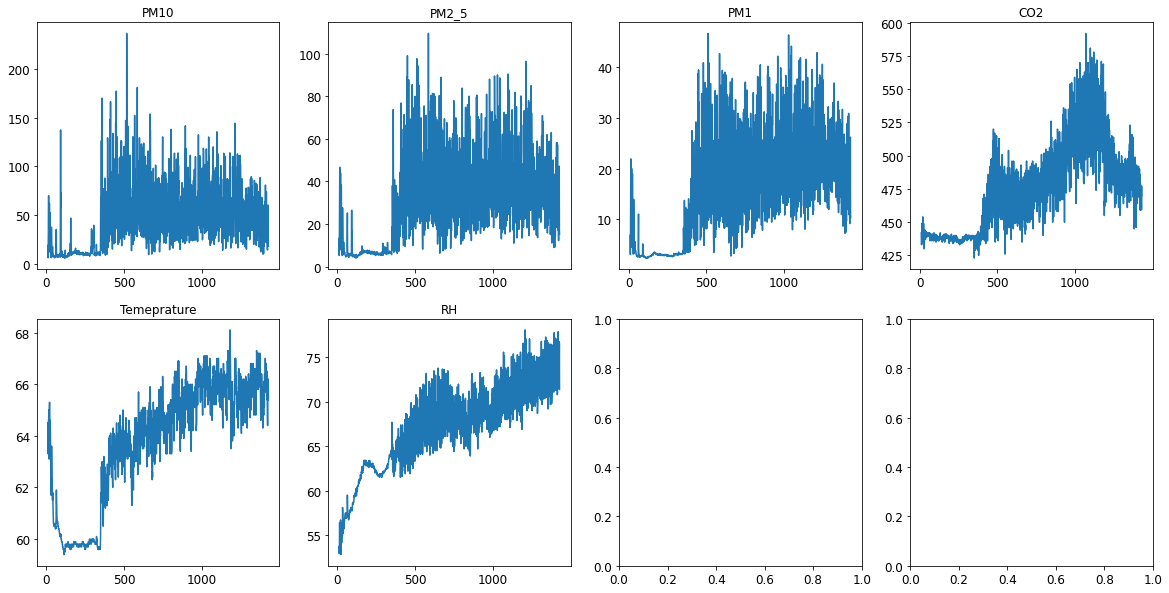

In [60]:
#scaler inverse_transform
X_train = scaler.inverse_transform(((X_train_scaled)))
X_train.shape 

fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    #a=i+1
    ax.flatten()[i].plot(X_train[:,0], X_train[:,i+1])
    ax.flatten()[i].set_title(group)
plt.savefig('./output/Figures/Individual/02Sample'+'_v'+str(k)+'.png')

### Preparing the training dataset

In [61]:
def concat_timesteps(X_train_scaled, ntimes, step):
    X_train_concat = []
    for i in range(len(X_train_scaled) - ntimes*step):
        X_train_concat.append(X_train_scaled[i:i+ntimes*step:step])
    return np.array(X_train_concat)

ntimes = 100 # Consecutive times for the GAN
step = 1 # step between times (1 mins)

X_train_concat = concat_timesteps(X_train_scaled, ntimes, step)#X_train_scaled
X_train_concat = X_train_concat.reshape(X_train_concat.shape[0],ntimes,n_features,1)
print(X_train_concat.shape)


(1319, 100, 7, 1)


In [62]:
BATCH_SIZE = 256
latent_space = 50

# Predict with the GAN

## Predict one point (start at n=0)

In [63]:
n = 500
epochs = 2



epoch=30000 #model's epoch

(1, 100, 7, 1)
(1, 100, 7, 1)
Loss:  0.09763912


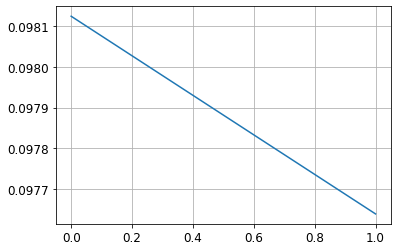

In [64]:
mse = tf.keras.losses.MeanSquaredError()
def mse_loss(inp, outp):
    """
    Find the mean squared error of a prediction
 
    Parameters
    ----------
    inp : numpy.ndarray
       Generated values of the POD coefficients
    ontp : numpy.ndarray
       Real POD coefficients
 
    Returns
    -------
    float
        mean squared loss between inp and outp
    """
    inp = tf.reshape(inp, [-1, n_features])
    #print("inp: ", inp)
    outp = tf.reshape(outp, [-1, n_features])
    #print("outp:", outp)
    return mse(inp, outp)



def predict_coding(initial_pred, real_coding):
    loss = []
    for epoch in range(epochs):
        encoder_output = encoder(initial_pred, training=False)
        decoder_output = decoder(encoder_output, training=False)
        loss.append(mse_loss(real_coding, decoder_output).numpy())
        initial_pred[:,(ntimes - 1):,:,-1] = decoder_output[:,(ntimes - 1):,:,-1]
        #initial_pred = decoder_output

    plt.plot(loss)
    plt.grid()
    plt.show
        
    return decoder_output,loss



real_coding = X_train_concat[n].reshape((1, ntimes, X_train_concat.shape[2],1))
print(real_coding.shape)


initial_pred = X_train_concat[n].reshape(1,-1)
initial_pred[:,n_features*(ntimes - 1):] = initial_pred[:,n_features*(ntimes - 2):n_features*(ntimes - 1)]
initial_pred = initial_pred.reshape((1, ntimes, X_train_concat.shape[2],1))
print(initial_pred.shape)


prediction_values,loss = predict_coding(initial_pred, real_coding)
print('Loss: ', loss[-1])

X_generated :  (100, 7)


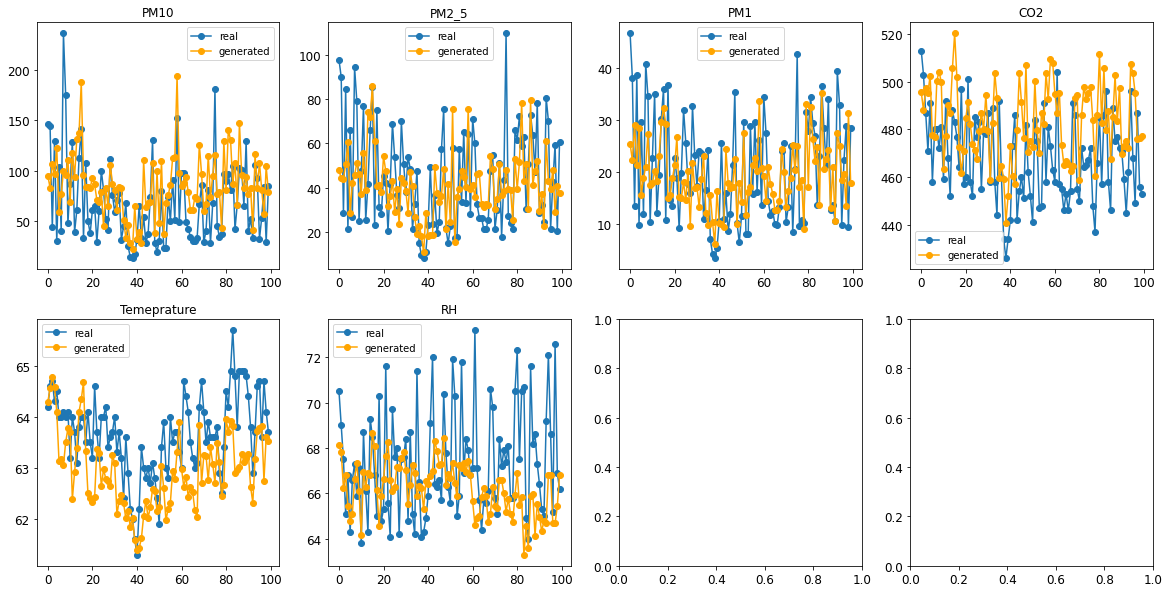

In [65]:
X_generated = prediction_values.numpy()
X_generated = scaler.inverse_transform((X_generated.reshape(ntimes, n_features)))
print('X_generated : ',X_generated.shape)


#X_real = scaler.inverse_transform((X_train_concat[n].reshape(ntimes,n_features)))
#X_real = X_real.reshape(ntimes, n_features)
#print('X_real : ',X_train[n:(n+ntimes+predict_points,:].shape)



fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_train[n:(n+ntimes),i+1], '-o', label='real')
    ax.flatten()[i].plot(X_generated[:,i+1], '-o',c='orange', label='generated')
    ax.flatten()[i].set_title(group)
    ax.flatten()[i].legend()
    
plt.savefig('./output/Figures/02_one_point_v'+str(k)+'_epoch_'+str(epoch)+'.png')

# Predict the whole simulation

### Start point = n = 0

In [66]:
epoch3 = 2 #2000
print(X_train.shape)
predict_points = X_train.shape[0]-n-ntimes
print(predict_points)

(1419, 7)
819


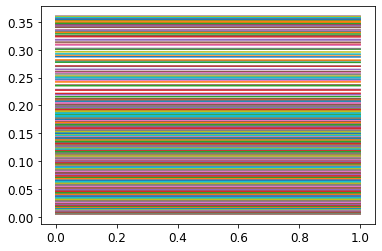

In [67]:
def predict_coding(initial_pred, real_coding):
    loss = []
    for epoch in range(epoch3):
        encoder_output = encoder(initial_pred, training=False)
        decoder_output = decoder(encoder_output, training=False)
        loss.append(mse_loss(real_coding, decoder_output).numpy())
        initial_pred[:,(ntimes - 1):,:] = decoder_output[:,(ntimes - 1):,:]
    
    plt.plot(loss)
    plt.grid()
    plt.show

    return decoder_output,loss

real_coding = X_train_concat[n].reshape((1, ntimes, X_train_concat.shape[2],1))

initial_pred = X_train_concat[n].reshape(1,-1)
initial_pred[:,n_features*(ntimes - 1):] = initial_pred[:,n_features*(ntimes - 2):n_features*(ntimes - 1)]
initial_pred = initial_pred.reshape((1, ntimes, X_train_concat.shape[2],1))

prediction_values,loss = predict_coding(initial_pred, real_coding)

X_predict = list(prediction_values.numpy().reshape(-1,n_features))
gen_predict = prediction_values[:,(ntimes - 1):,:]
real_coding = np.concatenate((real_coding, gen_predict), axis=1)[:,1:,:]
initial_pred = real_coding
initial_pred[:,(ntimes - 1):,:] = initial_pred[:,(ntimes - 2):(ntimes - 1),:]

for i in range(predict_points):
    prediction_values,loss = predict_coding(initial_pred, real_coding)
    gen_predict = prediction_values[:,(ntimes - 1):,:].numpy()
    X_predict.append(gen_predict.flatten())
    real_coding = np.concatenate((real_coding, gen_predict), axis=1)[:,1:,:]
    initial_pred = real_coding
    initial_pred[:,(ntimes - 1):,:] = initial_pred[:,(ntimes - 2):(ntimes - 1),:]
X_predict = np.array(X_predict)

(919, 7)


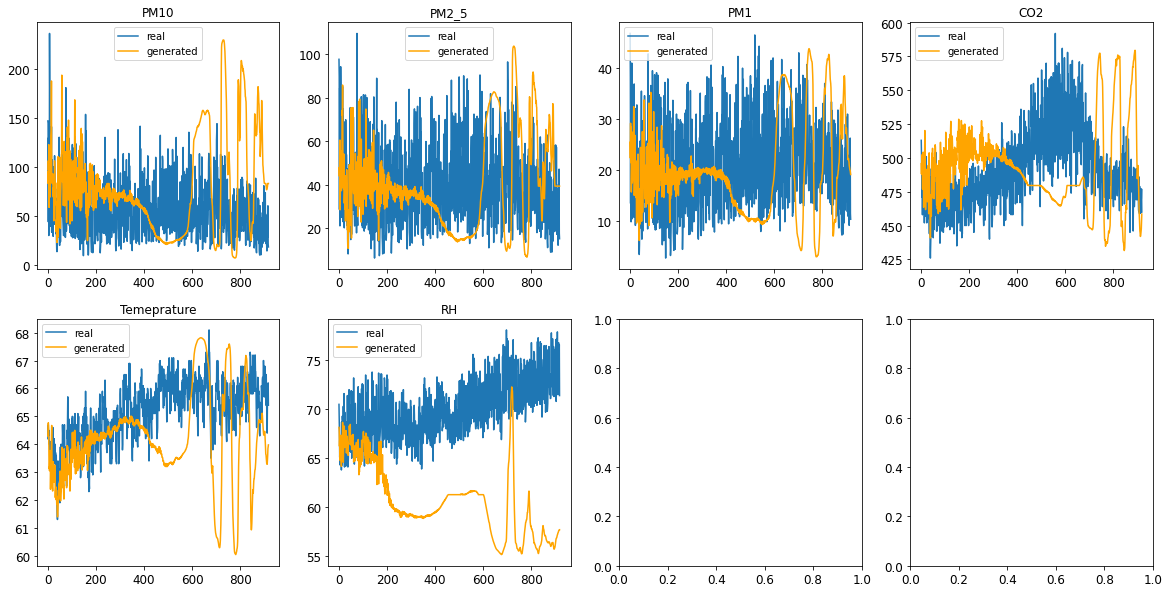

In [68]:
X_generated3 = scaler.inverse_transform(X_predict)
X_generated3 = X_generated3.reshape(len(X_predict), n_features)
X_generated3[X_generated3<0] = 0 

print(X_generated3.shape) #

fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_train[n:(n+ntimes+predict_points),i+1], '-', label='real')
    ax.flatten()[i].plot(X_generated3[:,i+1], '-',c='orange', label='generated')
    ax.flatten()[i].set_title(group)
    ax.flatten()[i].legend()
    
plt.savefig('./output/Figures/02_all'+'_v'+str(k)+'_epoch_'+str(epoch)+'.png')

# 10/04

# Perparing Data

<function matplotlib.pyplot.show(close=None, block=None)>

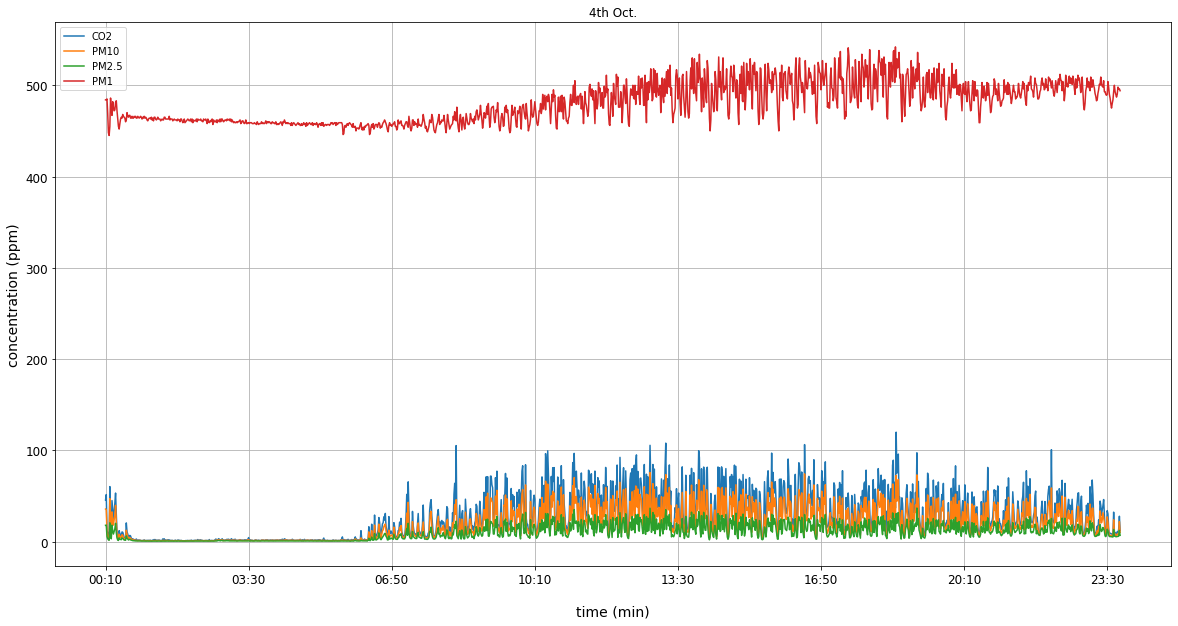

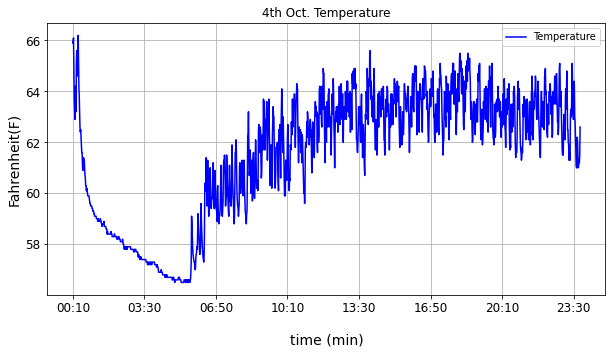

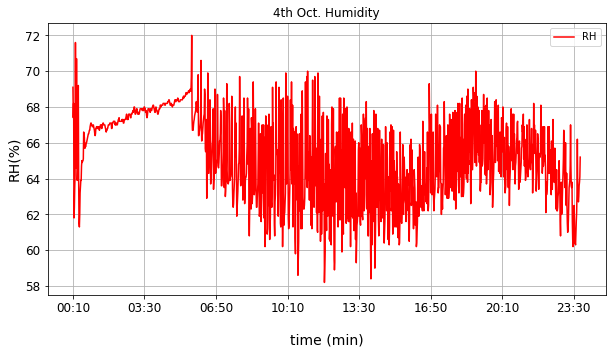

In [69]:
fig, ax = plt.subplots(1,1, figsize=[20,10]) 
ax.plot(times[:,0], data04[:,1], label='CO2') 
ax.plot(times[:,0], data04[:,2], label='PM10') 
ax.plot(times[:,0], data04[:,3], label='PM2.5') 
ax.plot(times[:,0], data04[:,4], label='PM1')

myLocator = mticker.MultipleLocator(200)
ax.xaxis.set_major_locator(myLocator)


ax.grid() 
plt.ylabel("concentration (ppm)") 
plt.xlabel("time (min)") 
plt.title('4th Oct.') 
plt.legend()
plt.savefig('./output/Figures/Sample_CO2+PM_04'+str(k)+'.png') 

fig, ax = plt.subplots(1,1, figsize=[10,5]) 
ax.plot(times[:,0], data04[:,5],c='blue', label='Temperature') 

myLocator = mticker.MultipleLocator(200)
ax.xaxis.set_major_locator(myLocator)



ax.grid() 
plt.ylabel("Fahrenheit(F)") 
plt.xlabel("time (min)") 
plt.title('4th Oct. Temperature') 
plt.legend()
plt.savefig('./output/Figures/Sample_Temp_04'+str(k)+'.png') 

fig, ax = plt.subplots(1,1, figsize=[10,5]) 
ax.plot(times[:,0], data04[:,6],c='red', label='RH') #what is the unit? 

myLocator = mticker.MultipleLocator(200)
ax.xaxis.set_major_locator(myLocator)


ax.grid() 
plt.ylabel("RH(%)") 
plt.xlabel("time (min)") 
plt.title('4th Oct. Humidity') 
plt.legend()

plt.savefig('./output/Figures/Sample_RH_04'+str(k)+'.png') 
plt.show

In [70]:
codings_size = n_features

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=[-1,1])
X_train_scaled = scaler.fit_transform(data04)

X_train_scaled.shape 


#scaler inverse_transform
X_train = scaler.inverse_transform(((X_train_scaled)))
X_train.shape 

(1419, 7)

In [71]:
def concat_timesteps(X_train_scaled, ntimes, step):
    X_train_concat = []
    for i in range(len(X_train_scaled) - ntimes*step):
        X_train_concat.append(X_train_scaled[i:i+ntimes*step:step])
    return np.array(X_train_concat)

ntimes = 100 # Consecutive times for the GAN
step = 1 # step between times (1 mins)

X_train_concat = concat_timesteps(X_train_scaled, ntimes, step)#X_train_scaled
X_train_concat = X_train_concat.reshape(X_train_concat.shape[0],ntimes,n_features,1)
print(X_train_concat.shape)
    

(1319, 100, 7, 1)


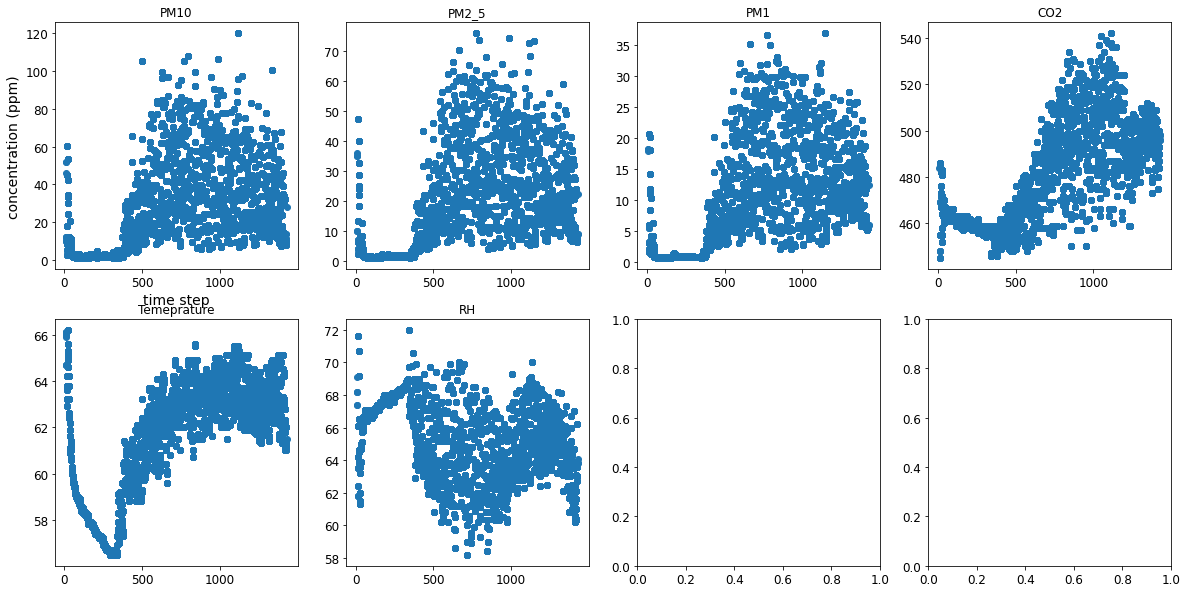

In [72]:
X_train_concat_flatten2 = X_train_concat.reshape(X_train_concat.shape[0]*ntimes, n_features).astype('float32')
X_train_concat_flatten2 = scaler.inverse_transform(X_train_concat_flatten2)


fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_train_concat_flatten2[:,0],X_train_concat_flatten2[:,i+1],'o')
    ax.flatten()[i].set_title(group)
    ax.flatten()[0].set_xlabel("time step")
    ax.flatten()[0].set_ylabel("concentration (ppm)")    
    
plt.savefig('./output/Figures/sample_04_v'+str(k)+'.png')

# One Point

In [73]:
n = 500
epochs = 2


epoch=10000 #model's epoch

(1, 100, 7, 1)
(1, 100, 7, 1)
Loss:  0.0693289


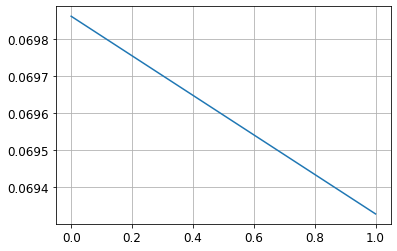

In [74]:
mse = tf.keras.losses.MeanSquaredError()
def mse_loss(inp, outp):
    """
    Find the mean squared error of a prediction
 
    Parameters
    ----------
    inp : numpy.ndarray
       Generated values of the POD coefficients
    ontp : numpy.ndarray
       Real POD coefficients
 
    Returns
    -------
    float
        mean squared loss between inp and outp
    """
    inp = tf.reshape(inp, [-1, n_features])
    #print("inp: ", inp)
    outp = tf.reshape(outp, [-1, n_features])
    #print("outp:", outp)
    return mse(inp, outp)



def predict_coding(initial_pred, real_coding):
    loss = []
    for epoch in range(epochs):
        encoder_output = encoder(initial_pred, training=False)
        decoder_output = decoder(encoder_output, training=False)
        loss.append(mse_loss(real_coding, decoder_output).numpy())
        initial_pred[:,(ntimes - 1):,:,-1] = decoder_output[:,(ntimes - 1):,:,-1]
        #initial_pred = decoder_output

    plt.plot(loss)
    plt.grid()
    plt.show
        
    return decoder_output,loss



real_coding = X_train_concat[n].reshape((1, ntimes, X_train_concat.shape[2],1))
print(real_coding.shape)


initial_pred = X_train_concat[n].reshape(1,-1)
initial_pred[:,n_features*(ntimes - 1):] = initial_pred[:,n_features*(ntimes - 2):n_features*(ntimes - 1)]
initial_pred = initial_pred.reshape((1, ntimes, X_train_concat.shape[2],1))
print(initial_pred.shape)


prediction_values,loss = predict_coding(initial_pred, real_coding)
print('Loss: ', loss[-1])

X_generated :  (100, 7)


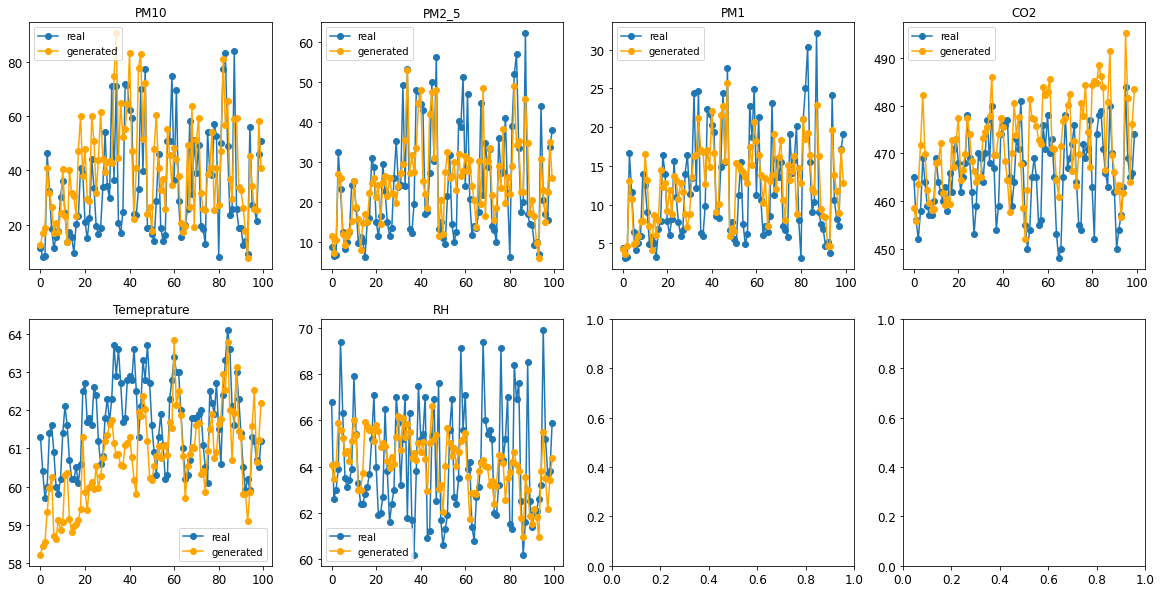

In [75]:
X_generated = prediction_values.numpy()
X_generated = scaler.inverse_transform((X_generated.reshape(ntimes, n_features)))
print('X_generated : ',X_generated.shape)


#X_real = scaler.inverse_transform((X_train_concat[n].reshape(ntimes,n_features)))
#X_real = X_real.reshape(ntimes, n_features)
#print('X_real : ',X_train[n:(n+ntimes+predict_points,:].shape)



fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_train[n:(n+ntimes),i+1], '-o', label='real')
    ax.flatten()[i].plot(X_generated[:,i+1], '-o',c='orange', label='generated')
    ax.flatten()[i].set_title(group)
    ax.flatten()[i].legend()
    
plt.savefig('./output/Figures/04_one_point_v'+str(k)+'_epoch_'+str(epoch)+'.png')

# All Day

In [76]:
epoch3 = 2#2000

print(X_train.shape)
predict_points = X_train.shape[0]-n-ntimes
print(predict_points)

(1419, 7)
819


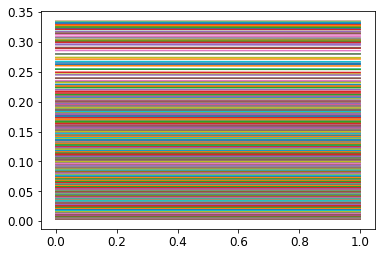

In [77]:
def predict_coding(initial_pred, real_coding):
    loss = []
    for epoch in range(epoch3):
        encoder_output = encoder(initial_pred, training=False)
        decoder_output = decoder(encoder_output, training=False)
        loss.append(mse_loss(real_coding, decoder_output).numpy())
        initial_pred[:,(ntimes - 1):,:] = decoder_output[:,(ntimes - 1):,:]
    
    plt.plot(loss)
    plt.grid()
    plt.show

    return decoder_output,loss

real_coding = X_train_concat[n].reshape((1, ntimes, X_train_concat.shape[2],1))

initial_pred = X_train_concat[n].reshape(1,-1)
initial_pred[:,n_features*(ntimes - 1):] = initial_pred[:,n_features*(ntimes - 2):n_features*(ntimes - 1)]
initial_pred = initial_pred.reshape((1, ntimes, X_train_concat.shape[2],1))

prediction_values,loss = predict_coding(initial_pred, real_coding)

X_predict = list(prediction_values.numpy().reshape(-1,n_features))
gen_predict = prediction_values[:,(ntimes - 1):,:]
real_coding = np.concatenate((real_coding, gen_predict), axis=1)[:,1:,:]
initial_pred = real_coding
initial_pred[:,(ntimes - 1):,:] = initial_pred[:,(ntimes - 2):(ntimes - 1),:]

for i in range(predict_points):
    prediction_values,loss = predict_coding(initial_pred, real_coding)
    gen_predict = prediction_values[:,(ntimes - 1):,:].numpy()
    X_predict.append(gen_predict.flatten())
    real_coding = np.concatenate((real_coding, gen_predict), axis=1)[:,1:,:]
    initial_pred = real_coding
    initial_pred[:,(ntimes - 1):,:] = initial_pred[:,(ntimes - 2):(ntimes - 1),:]
X_predict = np.array(X_predict)

(919, 7)


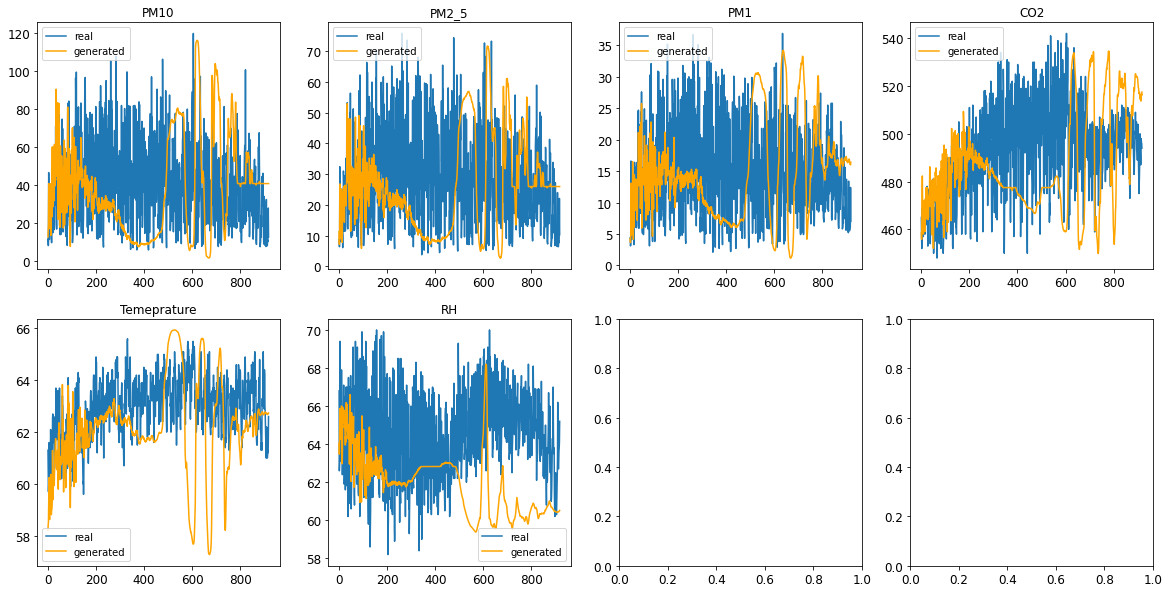

In [78]:
X_generated3 = scaler.inverse_transform(X_predict)
X_generated3 = X_generated3.reshape(len(X_predict), n_features)
X_generated3[X_generated3<0] = 0 


print(X_generated3.shape) #

fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_train[n:(n+ntimes+predict_points),i+1], '-', label='real')
    ax.flatten()[i].plot(X_generated3[:,i+1], '-',c='orange', label='generated')
    ax.flatten()[i].set_title(group)
    ax.flatten()[i].legend()
    
plt.savefig('./output/Figures/04_all'+'_v'+str(k)+'_epoch_'+str(epoch)+'.png')

In [79]:
#ae.save('./output/Figures/Prediction/New/v'+str(k)+'_epoch_'+str(epoch+1)+'.h5')    